In [1]:
import numpy as np
from glob import glob
from tqdm import tqdm_notebook as tqdm
import os
import shutil

import subtle.utils.io as suio
import matplotlib.pyplot as plt
plt.set_cmap('gray')
plt.rcParams['figure.figsize'] = (12, 8)

/home/srivathsa/projects/SubtleGad/train/subtle/utils/hyperparameter.py:8: UserWarning: Module test_tube not found - hyperparameter related functions cannot be used
  warnings.warn('Module test_tube not found - hyperparameter related functions cannot be used')


<Figure size 432x288 with 0 Axes>

In [3]:
base_path = '/home/srivathsa/projects/studies/gad/stanford/preprocess/data'

ignore = []

# ignore = ["Patient_0225", "Patient_0289", "Patient_0290", "Patient_0291", "Patient_0292", "Patient_0294", 
#           "Patient_0295", "Patient_0296", "Patient_0297", "Patient_0298", "Patient_0299", "Patient_0300", 
#           "Patient_0301", "Patient_0302", "Patient_0303", "Patient_0316", "Patient_0317", "Patient_0319", 
#           "Patient_0320", "Patient_0322", "Patient_0323", "Patient_0325", "Patient_0326", "Patient_0327", 
#           "Patient_0328", "Patient_0329", "Patient_0330", "Patient_0331", "Patient_0335", "Patient_0336", 
#           "Patient_0337", "Patient_0339", "Patient_0340", "Patient_0341", "Patient_0342", "Patient_0343",
#           "Patient_0429"]
kw = 'T2'
t1_files = sorted([f for f in glob('{}/*.npy'.format(base_path)) 
                   if 'T2' not in f and 'meta' not in f and 'FLAIR' not in f])
t1_files_filt = []
for t1f in t1_files:
    t2_fname = t1f.split('/')[-1].replace('.npy', '_{}.npy'.format(kw))
    case = t2_fname.replace('_{}.h5'.format(kw), '')
    t2_path = '{}/{}'.format(base_path, t2_fname)
    if os.path.isfile(t2_path) and not case in ignore:
        t1_files_filt.append(t1f)
t1_files = t1_files_filt
print(t1_files)
# t1_files = [f for f in t1_files if not os.path.exists(f.replace('.npy', '_full.npy'))]
# t2_missing_cnums = sorted([f.split('/')[-1].replace('.npy', '') for f in t1_files])

['/home/srivathsa/projects/studies/gad/stanford/preprocess/data/Patient_0303.npy']


In [9]:
base_path = '/home/srivathsa/projects/studies/gad/stanford/preprocess/data'
for fpath in sorted(glob('{}/*_full.npy'.format(base_path))):
    os.rename(fpath, fpath.replace('_full', ''))

In [5]:
save_path = '/home/srivathsa/projects/studies/gad/stanford/preprocess/data'

for t1_file in tqdm(t1_files, total=len(t1_files)):
    try:
#         t1_data = np.load(t1_file, mmap_mode='r+')
        t1_data = suio.load_file(t1_file, params={'h5_key': 'all'})
        t1_pre, t1_low, t1_full = t1_data.transpose(2, 0, 1, 3, 4)
        fpath_t2 = t1_file.replace('.npy', '_{}.npy'.format(kw))
        t2_data = suio.load_file(fpath_t2, params={'h5_key': 'all'})
        t1_new_file = t1_file.replace('.npy', '_full.npy')#.replace('data', 'data_fl')
        data_new = np.array([t1_pre, t1_low, t1_full, t2_data]).transpose(1, 2, 0, 3, 4)
        data_new = data_new.astype(np.float16)
        
        cnum = t1_file.split('/')[-1].replace('.npy', '')
        fpath_save = '{}/{}.npy'.format(save_path, cnum)
        suio.save_data_npy(t1_new_file, data=data_new)
#     np.save(t1_new_file, data_new)

        print('Saving new file to {}...'.format(t1_new_file))
        print('Data shape', data_new.shape)
#         os.remove(fpath_t2)
#         os.remove(t1_file)
    except Exception as exc:
        print('****Error in', t1_file)
        print('Error', exc)
        print('t1 shape', t1_data.shape)
        print('t2 shape', t2_data.shape, '****')

/home/srivathsa/miniconda3/envs/py35gad/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/1 [00:00<?, ?it/s]

Saving new file to /home/srivathsa/projects/studies/gad/stanford/preprocess/data/Patient_0303_full.npy...
Data shape (2, 344, 4, 512, 512)


In [37]:
data = suio.load_file('/home/srivathsa/projects/studies/gad/stanford/preprocess/data/Patient_0164_full.npy', 
                     params={'h5_key': 'all'}).astype(np.float32)

(2, 336, 4, 512, 512)


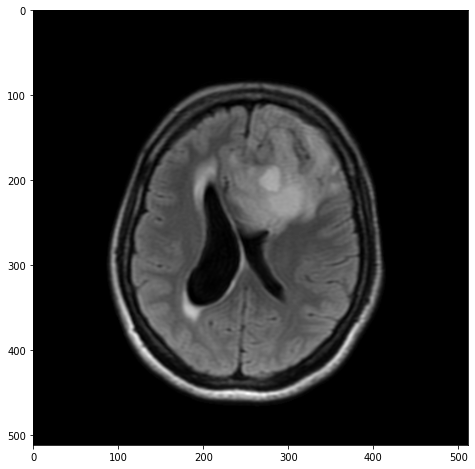

In [38]:
print(data.shape)
plt.imshow(data[0, 184, -1])

In [9]:
ignore_cases = sorted([c.split('/')[-1] for c in glob('/home/srivathsa/projects/studies/gad/tiantan/data/NO*')])
cases = sorted([c.split('/')[-1] for c in glob('/mnt/datasets/srivathsa/tiantan/Batch1/NO*')])
cases = [c for c in cases if c not in ignore_cases]

for case in cases:
    os.symlink(
        '/mnt/datasets/srivathsa/tiantan/Batch1/{}'.format(case), 
        '/home/srivathsa/projects/studies/gad/tiantan/data/{}'.format(case)
    )

In [7]:
dirpath_cases = sorted(glob('/mnt/datasets/srivathsa/tiantan/Batch1/*'))
flair_cases = []
for dircase in dirpath_cases:
    flair_ser = [d for d in glob('{}/*'.format(dircase)) if 'flair' in d.lower() and 'vista' in d.lower()]
    if len(flair_ser) == 1:
        flair_cases.append(dircase.split('/')[-1])

In [17]:
dest_dir = '/home/srivathsa/projects/studies/gad/tiantan/data'
src_dir = '/mnt/datasets/srivathsa/tiantan/Batch1'
for case in flair_cases:
    flair_ser = [
        d for d in glob('{}/{}/*'.format(src_dir, case, dircase)) 
        if 'flair' in d.lower() and 'vista' in d.lower()
    ][0]
    
    dest_path = os.path.join(dest_dir, case, flair_ser.split('/')[-1])
    print('ln -s {} {};'.format(flair_ser, dest_path))

ln -s /mnt/datasets/srivathsa/tiantan/Batch1/Brain2H-600441599/3DFLAIR-VISTA-SAG_CS7_Series0401 /home/srivathsa/projects/studies/gad/tiantan/data/Brain2H-600441599/3DFLAIR-VISTA-SAG_CS7_Series0401;
ln -s /mnt/datasets/srivathsa/tiantan/Batch1/Case1/3DFLAIR-VISTA-SAG_CS7_Series0401 /home/srivathsa/projects/studies/gad/tiantan/data/Case1/3DFLAIR-VISTA-SAG_CS7_Series0401;
ln -s /mnt/datasets/srivathsa/tiantan/Batch1/NO11/3DFLAIR-VISTA-SAG_CS7_Series0401 /home/srivathsa/projects/studies/gad/tiantan/data/NO11/3DFLAIR-VISTA-SAG_CS7_Series0401;
ln -s /mnt/datasets/srivathsa/tiantan/Batch1/NO12/3DFLAIR-VISTA-SAG_CS7_Series0401 /home/srivathsa/projects/studies/gad/tiantan/data/NO12/3DFLAIR-VISTA-SAG_CS7_Series0401;
ln -s /mnt/datasets/srivathsa/tiantan/Batch1/NO13/3DFLAIR-VISTA-SAG_CS7_Series0401 /home/srivathsa/projects/studies/gad/tiantan/data/NO13/3DFLAIR-VISTA-SAG_CS7_Series0401;
ln -s /mnt/datasets/srivathsa/tiantan/Batch1/NO14/3DFLAIR-VISTA-SAG_CS7_Series0401 /home/srivathsa/projects/stud

In [19]:
data = suio.load_file('/home/srivathsa/projects/studies/gad/stanford/preprocess/data/Patient_0325.npy',
                     params={'h5_key': 'all'})
print(data.shape)

(2, 320, 3, 512, 512)


In [21]:
proc_cases = [c.split('/')[-1].replace('_FLAIR.h5', '')
              for c in glob('/home/srivathsa/projects/studies/gad/tiantan/preprocess/data/*FLAIR*')]
err_cases = [c for c in flair_cases if c not in proc_cases]
print(err_cases)

['NO25', 'NO26', 'NO5']


In [5]:
src_meta = '/home/srivathsa/projects/studies/gad/tiantan/preprocess/data'
dest_path = '/home/srivathsa/projects/studies/gad/tiantan/preprocess/data_fl'

for fpath_h5 in glob('{}/*.h5'.format(dest_path)):
    case = fpath_h5.split('/')[-1].replace('.h5', '')
    fpath_meta = '{}/{}_meta.h5'.format(src_meta, case)
    shutil.copyfile(fpath_meta, fpath_meta.replace('data', 'data_fl'))

In [15]:
t2_files = sorted([f for f in glob('/home/srivathsa/projects/studies/gad/tiantan/preprocess/data_fl/*.h5') if 'meta' not in f])

for fpath in tqdm(t2_files, total=len(t2_files)):
    full_data = suio.load_file(fpath, params={'h5_key': 'all'})
    if full_data.shape[2] != 4:
        continue
    print('Processing {}...'.format(fpath.split('/')[-1].replace('.h5', '')))
    fpath_meta = fpath.replace('.h5', '_meta.h5')
    meta = suio.load_h5_metadata(fpath_meta)
    t2_full = full_data[1, :, 3]
    quant = np.quantile(t2_full, 0.9)
    meta['t2_csf_quant'] = quant
    suio.save_meta_h5(fpath_meta, meta)

Processing Brain2H-600441599...
Processing Case1...
Processing NO11...
Processing NO12...
Processing NO13...
Processing NO14...
Processing NO17...
Processing NO19...
Processing NO20...
Processing NO21...
Processing NO22...
Processing NO23...
Processing NO24...
Processing NO25...
Processing NO26...
Processing NO27...
Processing NO29...
Processing NO3...
Processing NO30...
Processing NO31...
Processing NO32...
Processing NO33...
Processing NO34...
Processing NO35...
Processing NO36...
Processing NO37...
Processing NO38...
Processing NO39...
Processing NO4...
Processing NO40...
Processing NO41...
Processing NO42...
Processing NO43...
Processing NO44...
Processing NO45...
Processing NO46...
Processing NO47...
Processing NO48...
Processing NO49...
Processing NO5...
Processing NO50...
Processing NO51...
Processing NO52...
Processing NO53...
Processing NO54...
Processing NO55...
Processing NO56...
Processing NO57...
Processing NO58...
Processing NO59...
Processing NO6...
Processing NO60...
Pr

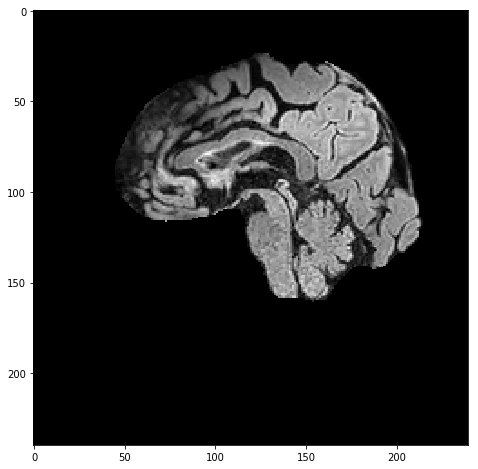

In [14]:
data = suio.load_file('/home/srivathsa/projects/studies/gad/tiantan/preprocess/data_fl/Case1.h5', params={'h5_key': 'all'})
data = data[1, :, 3]
q = np.quantile(data, 0.9)

plt.imshow(data[100])

In [28]:
base_path = '/home/srivathsa/projects/studies/gad/tiantan/preprocess/data'
h5_files = sorted([f for f in glob('{}/*.h5'.format(base_path)) if 'meta' not in f])
t2_cases = []
for fpath_h5 in tqdm(h5_files, total=len(h5_files)):
    data_h5 = suio.load_file(fpath_h5, params={'h5_key': 'all'})
    if data_h5.shape[2] == 4:
        t2_cases.append(fpath_h5)
#         data_mod = data_h5[:, :, :3, ...]
#         suio.save_data_h5(fpath_h5.replace('data', 'data/t1_only'), data=data_mod[0], data_mask=data_mod[1])

In [29]:
len(t2_cases)

77

In [16]:
skey = lambda s: int(s.replace('NO', '').replace('_mod', '')) if 'NO' in s else s
t2_list = [t2c for t2c in t2_cases if 'NO' in t2c]
t2_list = sorted(t2_list, key=skey)

In [25]:
for fpath_h5 in glob('/home/srivathsa/projects/studies/gad/tiantan/preprocess/data/*_full.h5'):
    fpath_mod = fpath_h5.replace('_full', '')
    os.remove(fpath_mod)

### Combine T1, T2 and FLAIR

In [6]:
t2_base_path = '/home/srivathsa/projects/studies/gad/tiantan/preprocess/data'
fl_base_path = '/home/srivathsa/projects/studies/gad/tiantan/preprocess/data_fl'

t1_files = sorted([
    f for f in glob('{}/*.h5'.format(t2_base_path)) 
    if 'meta' not in f and 'Prisma' not in f and 'TwoDim' not in f
])

t2_cases = []

for fpath in tqdm(t1_files, total=len(t1_files)):
    data = suio.load_file(fpath)
    if data.shape[1] == 4:
        t2_cases.append(fpath.split('/')[-1].replace('.h5', ''))

In [14]:
fl_cases = sorted([
    f.split('/')[-1].replace('.h5', '') 
    for f in glob('{}/*.h5'.format(fl_base_path)) 
    if 'meta' not in f
])

t2_fl_cases = sorted([c for c in t2_cases if c in fl_cases])

In [26]:
dest_dir = '/home/srivathsa/projects/studies/gad/tiantan/preprocess/data_t2_fl'

for case in tqdm(t2_fl_cases, total=len(t2_fl_cases)):
    t2_data = suio.load_file('{}/{}.h5'.format(t2_base_path, case), params={'h5_key': 'all'})
    fl_data = suio.load_file('{}/{}.h5'.format(fl_base_path, case), params={'h5_key': 'all'})
    
    t2_fl = np.append(t2_data, fl_data[:, :, 3][:, :, None, ...], axis=2)
    
    suio.save_data_h5('{}/{}.h5'.format(dest_dir, case), data=t2_fl[0], data_mask=t2_fl[1])

In [17]:
dcm, _ = suio.dicom_files('/home/srivathsa/projects/studies/gad/tiantan/data/Brain2H-600441599/3DFLAIR-VISTA-SAG_CS7_Series0401')

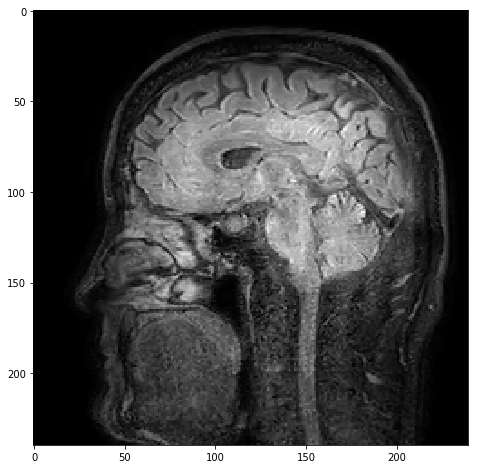

In [20]:
plt.imshow(dcm[88])

In [29]:
for case in t2_fl_cases:
    try:
        shutil.copyfile('{}/{}_meta.h5'.format(t2_base_path, case), '{}/{}_meta.h5'.format(dest_dir, case))
    except Exception as exc:
        print(exc)